# XAU - D1 Alpha Research

looking into the daily candlesticks formed for xauusd inorder to predict the daily candle close for the next day.

1) Candle type
2) Daily Volume 
3) Pips Difference b/w open and close
4) Price Change in %

Aim: Predict the next daily candle and use a short term momentum strategy to take the trades within that day.

In [3]:
import pandas as pd
from datetime import datetime
import MetaTrader5 as mt5
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cycler
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
import vectorbt as vbt


# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
# import matplotlib.pyplot as plt
# from matplotlib import cycler

# Colouring the charts
def plt_dark():
       colors = cycler('color',
                     ['#669FEE', '#66EE91', '#9988DD',
                     '#EECC55', '#88BB44', '#FFBBBB'])
       plt.rc('figure', facecolor='#313233')
       plt.rc('axes', facecolor="#313233", edgecolor='none',
              axisbelow=True, grid=True, prop_cycle=colors,
              labelcolor='gray')
       plt.rc('grid', color='474A4A', linestyle='solid')
       plt.rc('xtick', color='gray')
       plt.rc('ytick', direction='out', color='gray')
       plt.rc('legend', facecolor="#313233", edgecolor="#313233")
       plt.rc("text", color="#C9C9C9")
       plt.rc('figure', facecolor='#313233')
plt_dark()

## Log Regression for Daily chart. Predicting next day candles

In [4]:
# Writing a Function for pulling in data for different Pairs from MT5

# Settings 
symbol = 'XAUUSD'
timeframe = mt5.TIMEFRAME_D1
start_date = datetime(2010, 1, 1)
end_date = datetime(2023, 10, 30)

# Function 
def GetMTData():
    mt5.initialize()
    bars = pd.DataFrame(mt5.copy_rates_range(symbol, timeframe, start_date, end_date))
    bars['time'] = pd.to_datetime(bars['time'], unit='s')
    return bars

xauusd = GetMTData()


# Cleaning the Data

df_filter = xauusd[['time','close','tick_volume']]

df_filter['close'] = df_filter['close'].pct_change() * 100
# df_filter["tick_volume"] = xauusd["tick_volume"].shift(1).values / 1000_000_000
df_filter = df_filter.rename(columns={ 'close': 'Today', 'tick_volume': 'Volume'})

for i in range(1,6):
    df_filter["Lag " + str(i)] = df_filter["Today"].shift(i)
    
df_filter = df_filter.dropna()
df_filter["Direction"] = [1 if i > 0 else 0 for i in df_filter["Today"]]

X = df_filter[["Lag 1", "Lag 2", "Lag 3", "Lag 4", "Lag 5", "Volume"]]
y = df_filter[["Direction"]]


#Training the model

x_train, x_test, y_train, y_test = train_test_split(
X, y, test_size=0.30, random_state=4
)
clf = LogisticRegression().fit(x_train, y_train)
clf.score(x_test, y_test)

0.5422343324250681

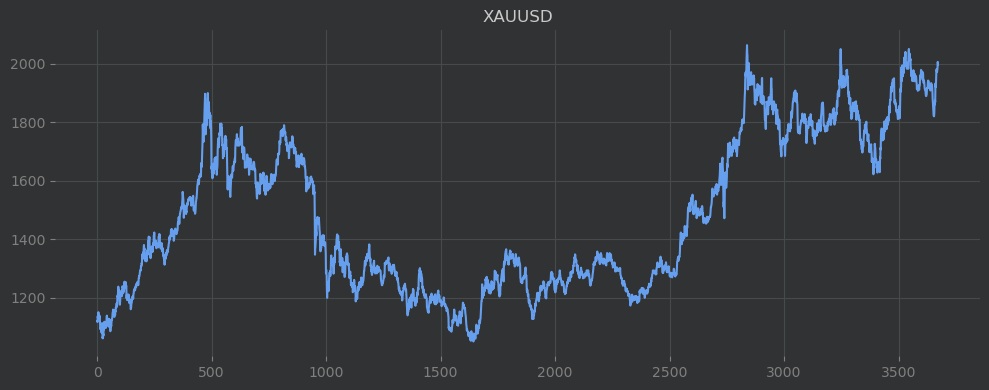

In [5]:
# Plotting the figue
def PlotCloseData(data):
    plt.figure(figsize = (10,4))
    plt.plot(data.close)
    #plt.grid(False)
    plt.title('XAUUSD')
    plt.tight_layout()
   
PlotCloseData(xauusd)

## Anomaly Detection

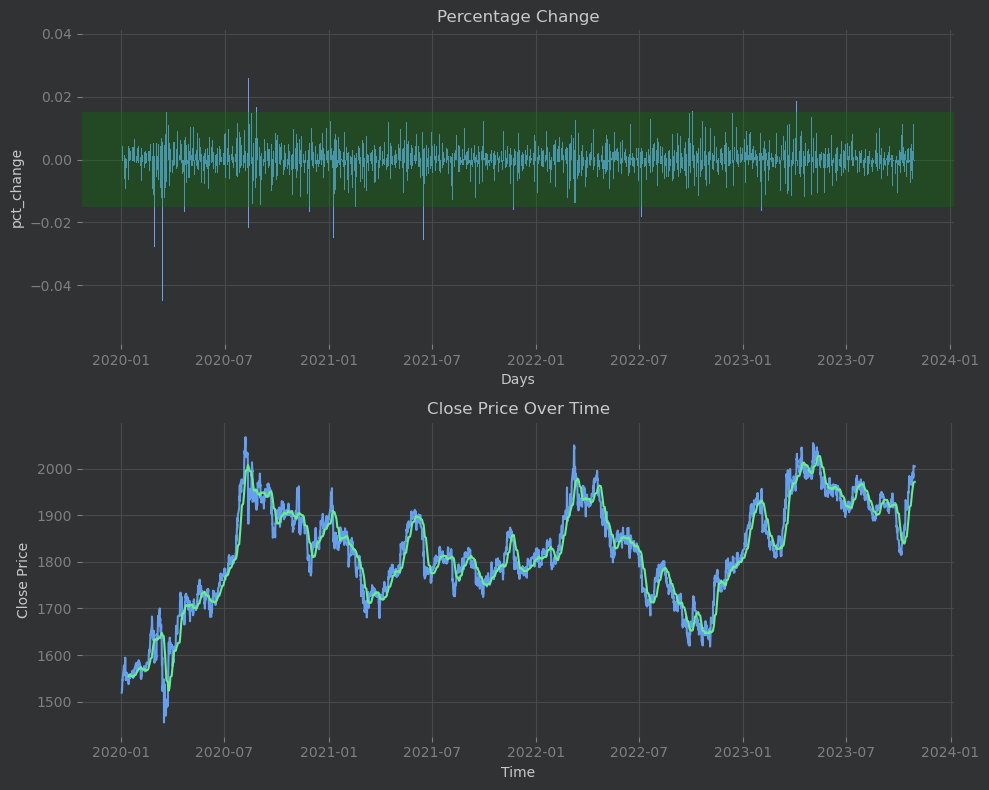

In [6]:
# Getting Data
symbol = 'XAUUSD'
timeframe = mt5.TIMEFRAME_H4
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 10, 30)

# Function 
def GetMTData():
    mt5.initialize()
    bars = pd.DataFrame(mt5.copy_rates_range(symbol, timeframe, start_date, end_date))
    bars['time'] = pd.to_datetime(bars['time'], unit='s')
    return bars

xauusd = GetMTData()

# Data Cleaning
xauusd['change%'] = xauusd['close'].pct_change()

# Create a figure with two subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plotting pct change
ax[0].bar(xauusd['time'], xauusd['change%'])
ax[0].set_xlabel('Days')
ax[0].set_ylabel('pct_change')
ax[0].set_title('Percentage Change')

# Add a colored rectangle for the specified y-axis range
ax[0].axhspan(-0.015, 0.015, facecolor='green', alpha=0.3, label='Threshold Range')

ma_50 = xauusd['close'].rolling(window=50).mean()

# Plotting bar graph of the same timeframe
ax[1].plot(xauusd['time'], xauusd['close'], label="Close")
ax[1].plot(xauusd['time'], ma_50, label="Close")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Close Price')
ax[1].set_title('Close Price Over Time')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

### Using H4 timeframe and its statistical description to markeup and time trades

count    1745.000000
mean        0.000061
std         0.003321
min        -0.016499
25%        -0.001321
50%         0.000000
75%         0.001491
max         0.022712
Name: change%, dtype: float64


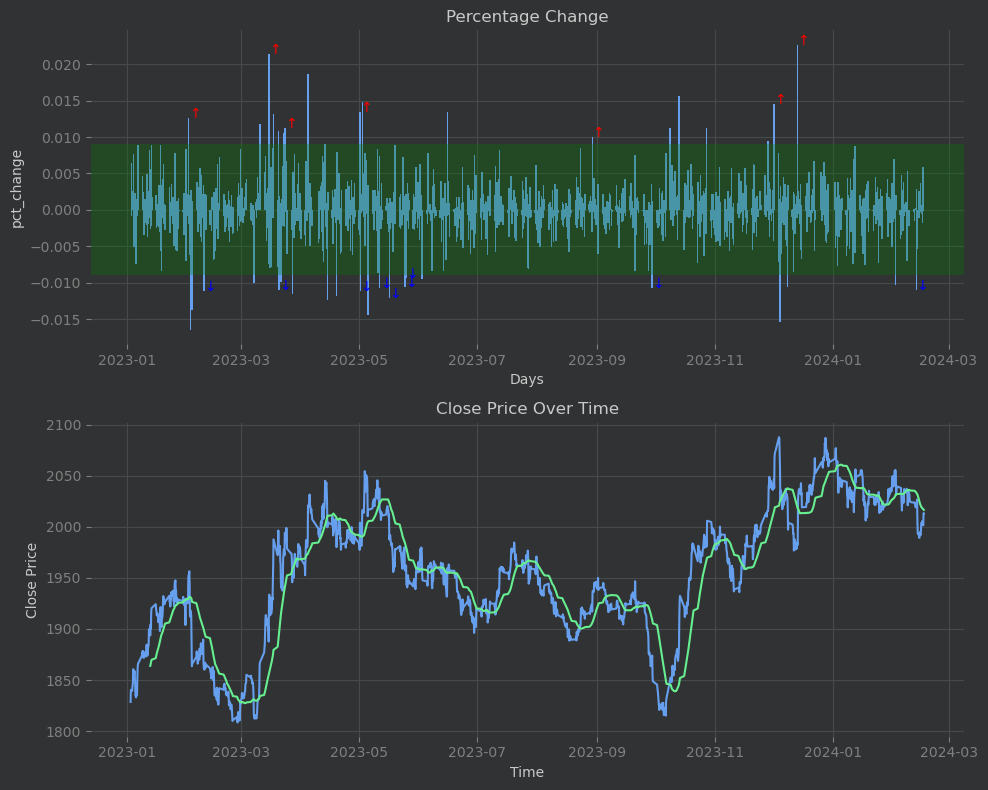

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import MetaTrader5 as mt5

# Initialize MetaTrader 5
mt5.initialize()

symbol = 'XAUUSD'
timeframe = mt5.TIMEFRAME_H4
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 2, 17)

def GetMTData():
    bars = pd.DataFrame(mt5.copy_rates_range(symbol, timeframe, start_date, end_date))
    bars['time'] = pd.to_datetime(bars['time'], unit='s')
    return bars

xauusd = GetMTData()

# Calculate percentage change
xauusd['change%'] = xauusd['close'].pct_change()
print(xauusd['change%'].describe())

# Create a figure with two subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot percentage change
ax[0].bar(xauusd['time'], xauusd['change%'])
ax[0].set_xlabel('Days')
ax[0].set_ylabel('pct_change')
ax[0].set_title('Percentage Change')

# Add a colored rectangle for the specified y-axis range
ax[0].axhspan(-0.0090, 0.0090, facecolor='green', alpha=0.3, label='Threshold Range')

# Add arrows for positive and negative crossings
for i in range(1, len(xauusd)):
    if -0.0090 < xauusd['change%'][i] < 0.0090:
        continue
    elif xauusd['change%'][i] > 0 and xauusd['change%'][i - 1] <= 0:
        ax[0].annotate('↑', xy=(xauusd['time'][i], xauusd['change%'][i]), color='red', fontsize=10)
    elif xauusd['change%'][i] < 0 and xauusd['change%'][i - 1] >= 0:
        ax[0].annotate('↓', xy=(xauusd['time'][i], xauusd['change%'][i]), color='blue', fontsize=10)

# Moving average
ma_50 = xauusd['close'].rolling(window=50).mean()

# Plot close price and moving average
ax[1].plot(xauusd['time'], xauusd['close'], label="Close")
ax[1].plot(xauusd['time'], ma_50, label="50-MA")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Close Price')
ax[1].set_title('Close Price Over Time')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


                            OLS Regression Results                            
Dep. Variable:                change%   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1990
Date:                Tue, 26 Mar 2024   Prob (F-statistic):              0.656
Time:                        00:50:24   Log-Likelihood:                 7484.0
No. Observations:                1745   AIC:                        -1.496e+04
Df Residuals:                    1743   BIC:                        -1.495e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.767      0.4

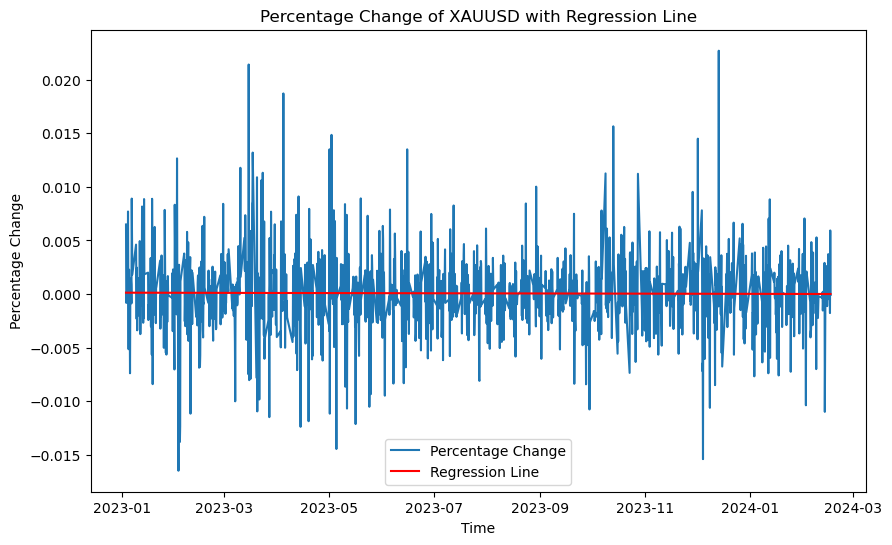

In [1]:
'''
Performing a regression analysis on the pct_change of xauusd close on the 4H 
'''


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import MetaTrader5 as mt5
import statsmodels.api as sm

# Initialize MetaTrader 5
mt5.initialize()

symbol = 'XAUUSD'
timeframe = mt5.TIMEFRAME_H4
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 2, 17)

def GetMTData():
    bars = pd.DataFrame(mt5.copy_rates_range(symbol, timeframe, start_date, end_date))
    bars['time'] = pd.to_datetime(bars['time'], unit='s')
    return bars

xauusd = GetMTData()

# Calculate percentage change
xauusd['change%'] = xauusd['close'].pct_change()

# Drop NaN values
xauusd = xauusd.dropna()

# Perform regression analysis
X = sm.add_constant(xauusd.index)  # Add constant for intercept term
y = xauusd['change%']

model = sm.OLS(y, X)
results = model.fit()

# Print regression summary
print(results.summary())

# Create a figure with a single subplot
plt.figure(figsize=(10, 6))

# Plot percentage change
plt.plot(xauusd['time'], xauusd['change%'], label='Percentage Change')

# Plot regression line
plt.plot(xauusd['time'], results.fittedvalues, label='Regression Line', color='red')

# Add labels and legend
plt.xlabel('Time')
plt.ylabel('Percentage Change')
plt.title('Percentage Change of XAUUSD with Regression Line')
plt.legend()

# Show the plot
plt.show()


### Using VectorBT to backtest  the strategy 

In [8]:

# Assuming xauusd['change%'] is calculated earlier
xauusd['signal'] = 0  # Create a new column for trading signals

# Generate signals based on the previous candle
xauusd.loc[(xauusd['change%'].shift(1) > 0.0090), 'signal'] = -1  # Sell (negative signal) when %change > 0.0090 in the previous candle
xauusd.loc[(xauusd['change%'].shift(1) < -0.0090), 'signal'] = 1   # Buy (positive signal) when %change < -0.0090 in the previous candle

# Extract buy and sell signals
buys = (xauusd['signal'] == 1)
sells = (xauusd['signal'] == -1)

# Create a Portfolio from signals
pf = vbt.Portfolio.from_signals(
    close=xauusd['close'],
    entries=buys,
    #exits=sells,
    sl_stop=0.03,
    size=1000,
    tp_stop=0.06
)

# Print portfolio statistics
print(pf.stats())



Start                            0.000000
End                           1745.000000
Period                        1746.000000
Start Value                    100.000000
End Value                      105.052556
Total Return [%]                 5.052556
Benchmark Return [%]            10.097674
Max Gross Exposure [%]         100.000000
Total Fees Paid                  0.000000
Max Drawdown [%]                 8.548347
Max Drawdown Duration          997.000000
Total Trades                     5.000000
Total Closed Trades              4.000000
Total Open Trades                1.000000
Open Trade PnL                  -0.819785
Win Rate [%]                    50.000000
Best Trade [%]                   6.342351
Worst Trade [%]                 -3.191990
Avg Winning Trade [%]            6.234343
Avg Losing Trade [%]            -3.143984
Avg Winning Trade Duration      58.500000
Avg Losing Trade Duration      222.000000
Profit Factor                    1.920540
Expectancy                       1

In [9]:
pf.plot().show()